In [652]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Analyzing the trained model

In [653]:
# import os; os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".99"

In [654]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from typing import Any, Callable, Sequence, Union
import numpy as np

import tensorflow as tf
tf.config.set_visible_devices([], device_type='GPU')

import jax
from jax import lax, random, numpy as jnp
from flax.core import freeze, unfreeze, FrozenDict, pop
from flax import linen as nn
from flax import struct
from flax.training import train_state
from flax.training import orbax_utils
import dm_pix as pix

import optax
import orbax.checkpoint

from clu import metrics
from ml_collections import ConfigDict

from einops import reduce, rearrange
import wandb
from iqadatasets.datasets import *
from fxlayers.layers import *
from fxlayers.layers import GaussianLayerGamma, GaborLayerLogSigma_, FreqGaussianGamma, OrientGaussianGamma, GaborLayerGamma_
from fxlayers.initializers import *
from JaxPlayground.utils.constraints import *
from JaxPlayground.utils.wandb import *

In [655]:
# jax.config.update("jax_debug_nans", False)

In [656]:
import matplotlib.pyplot as plt

In [751]:
USE_CIFAR = False
USE_IMAGENET = True
GRAYSCALE = False
C = 1 if GRAYSCALE else 3
assert not (USE_CIFAR and USE_IMAGENET)

## Define the model we're going to use

> It's going to be a very simple model just for demonstration purposes.

In [752]:
class PerceptNet(nn.Module):
    """IQA model inspired by the visual system."""
    n_scales: int
    n_orientations: int
    kernel_size: int
    phase: Sequence[float]
    fs: int
    strides: Sequence[Sequence[int]]

    @nn.compact
    def __call__(self,
                 inputs, # Assuming fs = 128 (cpd)
                 **kwargs,
                 ):
        outputs = pad_same_from_kernel_size(inputs, kernel_size=self.kernel_size, mode="symmetric")
        outputs = GaborLayerGamma_(n_scales=self.n_scales, n_orientations=self.n_orientations, kernel_size=self.kernel_size, phase=self.phase, fs=self.fs, xmean=self.kernel_size/self.fs/2, ymean=self.kernel_size/self.fs/2, normalize_prob=False, normalize_energy=True, zero_mean=True, padding="VALID")(outputs, **kwargs)
        outputs = self.param("B", nn.initializers.ones_init(), (outputs.shape[-1]))*outputs
        outputs = rearrange(outputs, "b h w (p t f) -> b h w (p t) f", f=self.n_scales, t=n_orientations, p=len(self.phase))
        outputs = [nn.max_pool(outputs[...,i], window_shape=s, strides=s) for i, s in enumerate(self.strides)]
        return outputs

## Define the metrics with `clu`

In [753]:
@struct.dataclass
class Metrics(metrics.Collection):
    """Collection of metrics to be tracked during training."""
    loss: metrics.Average.from_output("loss")

By default, `TrainState` doesn't include metrics, but it's very easy to subclass it so that it does:

In [754]:
class TrainState(train_state.TrainState):
    metrics: Metrics
    state: FrozenDict

We'll define a function that initializes the `TrainState` from a module, a rng key and some optimizer:

In [755]:
def create_train_state(module, key, tx, input_shape):
    """Creates the initial `TrainState`."""
    variables = module.init(key, jnp.ones(input_shape))
    state, params = variables.pop('params')
    return TrainState.create(
        apply_fn=module.apply,
        params=params,
        state=state,
        tx=tx,
        metrics=Metrics.empty()
    )

## Initialize

In [756]:
kernel_size = 63
n_scales = 6
n_orientations = 2
phase = jnp.array([0.])
fs = 512
state = create_train_state(PerceptNet(n_scales=n_scales, n_orientations=n_orientations, kernel_size=kernel_size, phase=phase, fs=fs, strides=[(1,1), (1,1), (1,1), (1,1), (2,2), (4,4)]),
                           random.PRNGKey(42),
                           optax.adam(3e-4),
                           input_shape=(1,64,64,C))

In [757]:
params = unfreeze(state.params)
## Gamma
params["GaborLayerGamma__0"]["gammax"] = params["GaborLayerGamma__0"]["gammax"]*2
params["GaborLayerGamma__0"]["gammay"] = params["GaborLayerGamma__0"]["gammay"]*2

## Orientations

## B
# params["B"] = jnp.array([1., 0., 0., 0.])

params = freeze(params)
state = state.replace(params=params)

In [758]:
state.params

FrozenDict({
    B: Array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32),
    GaborLayerGamma__0: {
        freq: Array([192.,  96.,  48.,  24.,  12.,   6.], dtype=float32),
        gammax: Array([53.66993  , 30.825277 , 17.704473 , 10.1685505,  5.840298 ,
                3.35437  ], dtype=float32),
        gammay: Array([42.935944 , 24.660223 , 14.163579 ,  8.134841 ,  4.672239 ,
                2.6834962], dtype=float32),
        sigma_theta: Array([0.       , 1.5707964], dtype=float32),
        theta: Array([0.       , 1.5707964], dtype=float32),
    },
})

In [759]:
pred, _ = state.apply_fn({"params": state.params, **state.state}, jnp.ones((1,32,32,C)), train=True, mutable=list(state.state.keys()))
state = state.replace(state=_)

In [760]:
for i in range(n_scales): print(pred[i].shape)

(1, 32, 32, 2)
(1, 32, 32, 2)
(1, 32, 32, 2)
(1, 32, 32, 2)
(1, 16, 16, 2)
(1, 8, 8, 2)


In [761]:
from functools import partial

In [762]:
# window = jnp.array([(1,1), (1,1), (2,2), (4,4)])
# strides = jnp.array([(1,1), (1,1), (2,2), (4,4)])
# window = jnp.array([(2,2)]*4)
# strides = jnp.array([(2,2)]*4)
# kks = jax.vmap(nn.max_pool, in_axes=(4,0,0))(pred[...,None,:], window, strides)

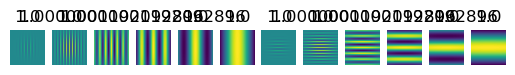

In [763]:
fig, axes = plt.subplots(1,state.state["precalc_filter"]["GaborLayerGamma__0"]["kernel"].shape[-1])
for i, ax in enumerate(axes.ravel()):
    ax.imshow(state.state["precalc_filter"]["GaborLayerGamma__0"]["kernel"][...,0,i])
    ax.set_title(f'{(state.state["precalc_filter"]["GaborLayerGamma__0"]["kernel"][...,0,i]**2).sum()**(1/2)}')
    ax.axis("off")
plt.show()

## Defining the training step

> We want to write a function that takes the `TrainState` and a batch of data can performs an optimization step.

In [764]:
def pearson_correlation(vec1, vec2):
    vec1 = vec1.squeeze()
    vec2 = vec2.squeeze()
    vec1_mean = vec1.mean()
    vec2_mean = vec2.mean()
    num = vec1-vec1_mean
    num *= vec2-vec2_mean
    num = num.sum()
    denom = jnp.sqrt(jnp.sum((vec1-vec1_mean)**2))
    denom *= jnp.sqrt(jnp.sum((vec2-vec2_mean)**2))
    return num/denom

In [765]:
@jax.jit
def train_step(state, batch):
    """Train for a single step."""
    img, img_dist, mos = batch
    def loss_fn(params):
        ## Forward pass through the model
        img_pred, updated_state = state.apply_fn({"params": params, **state.state}, img, mutable=list(state.state.keys()), train=True)
        img_dist_pred, updated_state = state.apply_fn({"params": params, **state.state}, img_dist, mutable=list(state.state.keys()), train=True)

        ## Calculate the distance
        dist = ((img_pred - img_dist_pred)**2).sum(axis=(1,2,3))**(1/2)
        
        ## Calculate pearson correlation
        return pearson_correlation(dist, mos), updated_state
    
    (loss, updated_state), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)
    metrics_updates = state.metrics.single_from_model_output(loss=loss)
    metrics = state.metrics.merge(metrics_updates)
    state = state.replace(metrics=metrics)
    state = state.replace(state=updated_state)
    return state

In their example, they don't calculate the metrics at the same time. I think it is kind of a waste because it means having to perform a new forward pass, but we'll follow as of now. Let's define a function to perform metric calculation:

In [766]:
@jax.jit
def compute_metrics(*, state, batch):
    """Obtaining the metrics for a given batch."""
    img, img_dist, mos = batch
    def loss_fn(params):
        ## Forward pass through the model
        img_pred, updated_state = state.apply_fn({"params": params, **state.state}, img, mutable=list(state.state.keys()), train=False)
        img_dist_pred, updated_state = state.apply_fn({"params": params, **state.state}, img_dist, mutable=list(state.state.keys()), train=False)

        ## Calculate the distance
        dist = ((img_pred - img_dist_pred)**2).sum(axis=(1,2,3))**(1/2)
        
        ## Calculate pearson correlation
        return pearson_correlation(dist, mos)
    
    metrics_updates = state.metrics.single_from_model_output(loss=loss_fn(state.params))
    metrics = state.metrics.merge(metrics_updates)
    state = state.replace(metrics=metrics)
    return state

## Recovering an image from noise

In [767]:
from functools import partial

In [768]:
@jax.jit
def forward(state, inputs):
    return state.apply_fn({"params": state.params, **state.state}, inputs, train=False)

In [769]:
def rmse(a, b):
    return jnp.sqrt(jnp.mean((a-b)**2, axis=(1,2,3)))

In [770]:
def rmse(a, b):
    return optax.safe_root_mean_squares(a-b, min_rms=0.)

In [771]:
@jax.jit
def compute_distance(state, img1, img2):
    def forward(state, inputs): return state.apply_fn({"params": state.params, **state.state}, inputs, train=False)
    pred_1 = forward(state, img1)
    pred_2 = forward(state, img2)
    return rmse(pred_1, pred_2)

In [772]:
if USE_CIFAR:
    from tensorflow.keras.datasets.cifar10 import load_data
    (X_train, _), (_, _) = load_data()
    X_train = X_train/255.0
    sample = X_train[0:1]
elif USE_IMAGENET:
    import cv2
    sample = cv2.imread("../pez_imagenet.jpeg")
    sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)
    sample = sample[None,:] / 255.0
if GRAYSCALE:
    sample = pix.rgb_to_grayscale(sample)
sample.shape

(1, 263, 376, 3)

In [773]:
img = random.uniform(random.PRNGKey(42), shape=sample.shape)
img.shape

(1, 263, 376, 3)

In [774]:
pred_sample = forward(state, sample)
pred_img = forward(state, img)

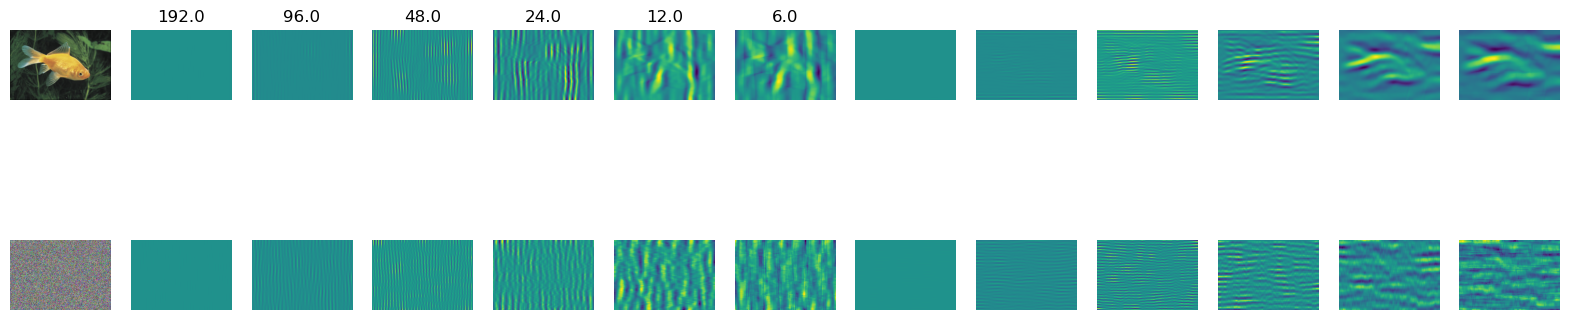

In [775]:
fig, axes = plt.subplots(2,n_scales*n_orientations+1, figsize=(20,5))
# for ax, im in zip(axes.ravel(), [sample, img]):
axes[0,0].imshow(sample[0])
axes[1,0].imshow(img[0])
for i in range(n_scales):
    axes[0,i+1].imshow(pred_sample[i][0,...,0:1])
    axes[0,i+1+n_scales].imshow(pred_sample[i][0,...,1:2])
    axes[0,i+1].set_title(state.params["GaborLayerGamma__0"]["freq"][i])
for i in range(len(pred_sample)):
    axes[1,i+1].imshow(pred_img[i][0,...,0:1])
    axes[1,i+1+n_scales].imshow(pred_img[i][0,...,1:2])
for ax in axes.ravel(): ax.axis("off")
# axes[0,1].set_title(f"{sample.min():.2f} / {im.max():.2f}")
plt.show()

In [776]:
[p.min() for p in pred_sample], [p.max() for p in pred_sample]

([Array(-1.676001, dtype=float32),
  Array(-3.102213, dtype=float32),
  Array(-3.1331806, dtype=float32),
  Array(-5.6038327, dtype=float32),
  Array(-17.749302, dtype=float32),
  Array(-18.539019, dtype=float32)],
 [Array(1.6474204, dtype=float32),
  Array(3.3351834, dtype=float32),
  Array(2.8677404, dtype=float32),
  Array(6.455821, dtype=float32),
  Array(22.68388, dtype=float32),
  Array(27.558313, dtype=float32)])

Define the optimization loop:

In [777]:
@jax.jit
def compute_distance_loss(state, img1, img2):
    def forward(state, inputs): return state.apply_fn({"params": state.params, **state.state}, inputs, train=False)
    pred_1 = forward(state, img1)
    pred_2 = forward(state, img2)
    return rmse(pred_1, pred_2).mean()

In [778]:
@partial(jax.jit, static_argnums=(1))
def optim_step(state, tx, tx_state, sample, img):
    def loss_fn(img):
        def forward(state, inputs): return state.apply_fn({"params": state.params, **state.state}, inputs, train=False)
        # pred_1 = forward(state, sample)
        pred_1 = pred_sample
        pred_2 = forward(state, img)
        return jnp.mean(jnp.array([rmse(a, b) for a, b in zip(pred_1, pred_2)]))
    loss, grads = jax.value_and_grad(loss_fn)(img)
    updates, tx_state = tx.update(grads, tx_state)
    img = optax.apply_updates(img, updates=updates)
    return img, loss, tx_state

In [779]:
@partial(jax.jit, static_argnums=(1))
def optim_step_rmse(state, tx, tx_state, sample, img):
    def loss_fn(img):
        return rmse(sample, img).mean()
    loss, grads = jax.value_and_grad(loss_fn)(img)
    updates, tx_state = tx.update(grads, tx_state)
    img = optax.apply_updates(img, updates=updates)
    return img, loss, tx_state

In [780]:
@partial(jax.jit, static_argnums=(1))
def optim_step_ssim(state, tx, tx_state, sample, img):
    def loss_fn(img):
        return 1-pix.ssim(sample, img).mean()
    loss, grads = jax.value_and_grad(loss_fn)(img)
    updates, tx_state = tx.update(grads, tx_state)
    img = optax.apply_updates(img, updates=updates)
    return img, loss, tx_state

In [781]:
EPOCHS = 5000
LEARNING_RATE = 3e-4
USE_RMSE = False
USE_SSIM = False
if USE_RMSE: name = "RMSE"
elif USE_SSIM: name = "1-SSIM"
else: name = "PerceptNet"

# tx = optax.sgd(learning_rate=LEARNING_RATE)
tx = optax.adam(learning_rate=LEARNING_RATE)
tx_state = tx.init(img)
img = random.uniform(random.PRNGKey(42), shape=sample.shape)
imgs = [jax.device_put(img, jax.devices("cpu")[0])]
losses, rmses = [], []

In [782]:
from tqdm.auto import tqdm

In [783]:
for epoch in tqdm(range(EPOCHS)):
    if USE_RMSE: img, loss, tx_state = optim_step_rmse(state, tx, tx_state, sample, img)
    elif USE_SSIM: img, loss, tx_state = optim_step_ssim(state, tx, tx_state, sample, img)
    else: img, loss, tx_state = optim_step(state, tx, tx_state, sample, img)

    img = jnp.clip(img, a_min=0., a_max=1.)
    imgs.append(jax.device_put(img, jax.devices("cpu")[0]))
    losses.append(loss)
    rmses.append(rmse(sample, img).mean())
    # print(f"Loss: {loss:.4f} | RMSE: {rmses[-1]}")
    # break

  0%|          | 0/5000 [00:00<?, ?it/s]

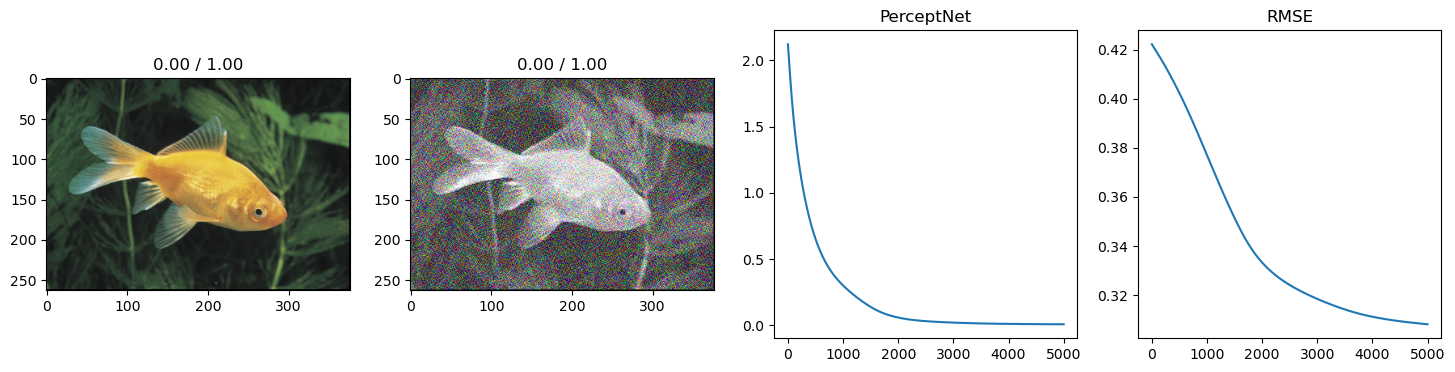

In [784]:
fig, axes = plt.subplots(1,4, figsize=(18,4))
axes[0].imshow(sample[0])
axes[1].imshow(img[0])
axes[2].plot(losses)
axes[3].plot(rmses)
axes[0].set_title(f"{sample.min():.2f} / {sample.max():.2f}")
axes[1].set_title(f"{img.min():.2f} / {img.max():.2f}")
axes[2].set_title(name)
axes[3].set_title("RMSE")
# axes[1].imshow((grads[0]+jnp.abs(grads.min()))/(grads[0]+jnp.abs(grads.min())).max())
plt.show()

In [785]:
pred_sample = forward(state, sample)
pred_img = forward(state, img)

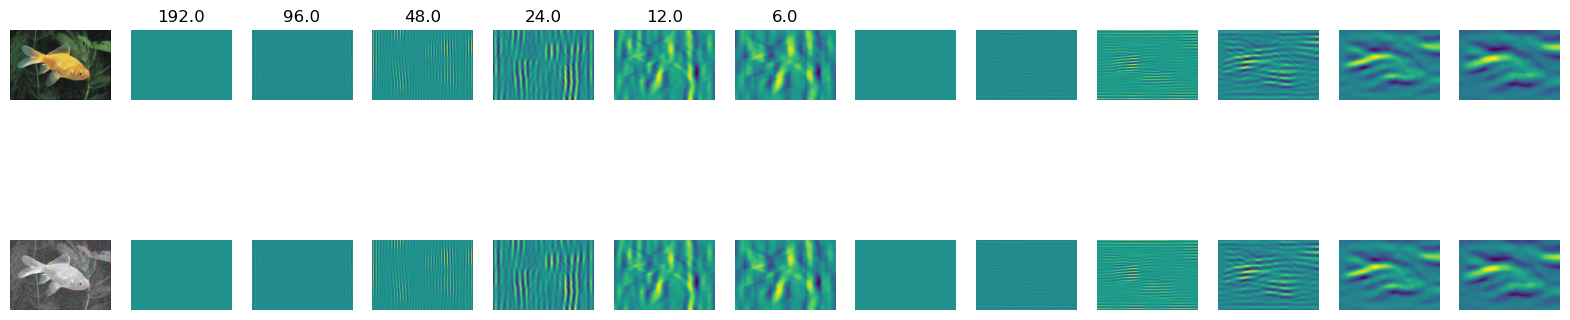

In [786]:
fig, axes = plt.subplots(2,n_scales*n_orientations+1, figsize=(20,5))
# for ax, im in zip(axes.ravel(), [sample, img]):
axes[0,0].imshow(sample[0])
axes[1,0].imshow(img[0])
for i in range(n_scales):
    axes[0,i+1].imshow(pred_sample[i][0,...,0:1])
    axes[0,i+1+n_scales].imshow(pred_sample[i][0,...,1:2])
    axes[0,i+1].set_title(state.params["GaborLayerGamma__0"]["freq"][i])
for i in range(len(pred_sample)):
    axes[1,i+1].imshow(pred_img[i][0,...,0:1])
    axes[1,i+1+n_scales].imshow(pred_img[i][0,...,1:2])
for ax in axes.ravel(): ax.axis("off")
# axes[0,1].set_title(f"{sample.min():.2f} / {im.max():.2f}")
plt.show()